<a href="https://colab.research.google.com/github/yussif-issah/css54FinalProject/blob/main/mangrove_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models,datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt

In [55]:
!pip install torcheval

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 KB 4.6 MB/s eta 0:00:004.9 MB/s eta 0:00:01


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
NUM_CLASSES = 3
TRAINING_DATA_PATH = "datamangrove/train"
VALIDATION_DATA_PATH="datamangrove/val"
TEST_DATA_PATH = "datamangrove/test"

In [24]:
model = models.resnet50(pretrained=True)

model.eval

<bound method Module.eval of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, ke

In [38]:
def buildModel(nn):
    model = models.resnet50(pretrained=True)
    head = nn.Sequential(
        nn.Linear(model.fc.in_features, NUM_CLASSES)
    )
    model.fc = head
    return model.to(device)

In [39]:
def buildDataLoader(batchSize):
    ttransform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    ])
  
    train_data = datasets.ImageFolder("datamangrove/train",transform=ttransform)
    val_data = datasets.ImageFolder("datamangrove/val",transform=ttransform)
    test_data = datasets.ImageFolder("datamangrove/train",transform=ttransform)

    train_data_loader = DataLoader(train_data,batch_size=batchSize,shuffle=True)
    val_data_loader = DataLoader(val_data,batch_size=batchSize,shuffle=True)
    test_data_loader = DataLoader(test_data,batch_size=24,shuffle=True)

    image_datasets = {"train":train_data,"val":val_data,"test":test_data}
    data_loaders = {"train": train_data_loader,"val":val_data_loader,"test":test_data_loader}

    return data_loaders,image_datasets

In [40]:
def buildOptimizer(model,learning_rate):
    #return optim(model.parameters(),lr=learning_rate)
    return optim.SGD(model.parameters(),lr=learning_rate, momentum=0.9)


In [41]:
criterion = nn.CrossEntropyLoss()

In [42]:
def trainModel(epochs,batch_size,learning_rate):

    data_loaders,datasets= buildDataLoader(batch_size)
    model = buildModel(torch.nn)
    optimizer = buildOptimizer(model,learning_rate)

    for epoch in range(epochs):

      for phase in ["train","val"]:

        if phase == "train":
          model.train()
        else:
          model.eval()

        running_loss = 0
        correct = 0

        for inputs,labels in data_loaders[phase]:
          inputs,labels = inputs.to(device),labels.to(device)

          optimizer.zero_grad()

          with torch.set_grad_enabled(phase=="train"):
            outputs = model(inputs)
            _,preds = torch.max(outputs,1)
            loss = criterion(outputs,labels)

            if phase == "train":
              loss.backward()
              optimizer.step()

          running_loss += loss.item()*inputs.size(0)
          correct += torch.sum(preds ==labels)

          epoch_loss = running_loss / len(datasets[phase])
          epoch_acc = correct.double() / len(datasets[phase])

          if phase == "train":
            print(f"epoch: {epoch+1} training loss {epoch_loss}, training accuracy {epoch_acc}")
          else:
            print(f"epoch: {epoch+1} validation loss {epoch_loss}, validation accuracy {epoch_acc}")
    torch.save(model.state_dict(),"resnet.pth")
    return data_loaders,model

In [43]:
data_loaders,model = trainModel(5,32,0.001640) #20,48,0.5,256,0.001640

epoch: 1 training loss 0.1721632297222431, training accuracy 0.04807692307692308
epoch: 1 training loss 0.3425139830662654, training accuracy 0.08653846153846154
epoch: 1 training loss 0.5051716657785269, training accuracy 0.16826923076923078
epoch: 1 training loss 0.6667785277733436, training accuracy 0.2403846153846154
epoch: 1 training loss 0.8169970879187951, training accuracy 0.34615384615384615
epoch: 1 training loss 0.9610399833092322, training accuracy 0.4567307692307693
epoch: 1 training loss 1.0272742830790007, training accuracy 0.5240384615384616
epoch: 1 validation loss 0.5349897791127689, validation accuracy 0.21311475409836067
epoch: 1 validation loss 1.0187374998311527, validation accuracy 0.4426229508196722
epoch: 2 training loss 0.1303256108210637, training accuracy 0.12980769230769232
epoch: 2 training loss 0.2525373880679791, training accuracy 0.27403846153846156
epoch: 2 training loss 0.3791687763654269, training accuracy 0.38461538461538464
epoch: 2 training loss 0

In [44]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
model = buildModel(torch.nn,256,0.2)

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/resnet.pth",map_location=torch.device('cpu')))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model = models.mobilenet_v3_large(pretrained=True)
head = nn.Sequential(
        nn.Linear(model.classifier[-1].in_features,256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, NUM_CLASSES)
  )
model.classifier[-1] = head #nn.Linear(model.classifier[-1].in_features,NUM_CLASSES)
model = model.to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/mobileNetLarge.pth",map_location=torch.device('cpu')))
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 103MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [46]:
ttransform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])
test_data = datasets.ImageFolder(TEST_DATA_PATH,transform = ttransform)
test_loader = DataLoader(test_data,batch_size=31,shuffle=False)

31

In [47]:

with torch.no_grad():
    for inputs,labels in test_loader:
        inputs, labels = inputs.to(device),labels.to(device)
        preds = model(inputs)


In [61]:
predictions = torch.max(preds,1).indices
multiclass_f1_score(labels,predictions).item()

1.0

(array([0, 1, 2]),
 [Text(0, 0, 'Avicennia Alba'),
  Text(1, 0, 'Rhizophora Apiculata'),
  Text(2, 0, 'Sonneratia Alba')])

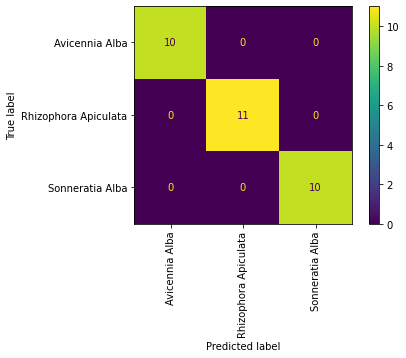

In [114]:
cm = confusion_matrix(labels.cpu().numpy(), predictions.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=test_loader.dataset.classes)
disp.plot()
plt.xticks(rotation=90)

In [112]:
report=  classification_report(labels.cpu().numpy(), predictions.cpu().numpy(),target_names=test_loader.dataset.classes)
print(report)

                      precision    recall  f1-score   support

      Avicennia Alba       1.00      1.00      1.00        10
Rhizophora Apiculata       1.00      1.00      1.00        11
     Sonneratia Alba       1.00      1.00      1.00        10

            accuracy                           1.00        31
           macro avg       1.00      1.00      1.00        31
        weighted avg       1.00      1.00      1.00        31

